# Incomplete Installation Prediction: Model Training

**Package Versions Required** \
`numpy` v. 1.18.5 \
`pandas` v. 1.1.1 \
`seaborn` v. 0.10.1

`google-cloud-bigquery` v. 1.26.1 \
`google-auth`: 1.21.1 \
`google-cloud-bigquery-storage`: 1.0.0 \
`google-cloud-storage`: 1.30.0 \
`google-cloud-core`: 1.3.0 \
`google-api-core`: 1.22.2 \
`google-resumable-media`: 0.7.1 \
`google-auth-oauthlib`: 0.4.1

`scikit-learn` v. 0.23.2 \
`xgboost`: 1.6.1 \
`mlxtend`: 0.19.0

In [ ]:
pip install category_encoders


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# import all the required dependecnies and modules

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#sns.set_theme(style="whitegrid")
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import time
import pickle
from google.cloud import bigquery
from google.oauth2 import service_account
# from google.cloud import bigquery_storage_v1
import string
import xgboost as xgb
import importlib
import utility as pp
import category_encoders as ce
import warnings
warnings.filterwarnings("ignore")

## Read the training data for specific month from BQ

In [2]:
import os
os.environ['gcp_service_account'] = 'ascendant-epoch-432900-m8-e97fb3b60497.json'

In [3]:
import json
# service_account_info = json.loads('ascendant-epoch-432900-m8-e97fb3b60497.json')

with open('ascendant-epoch-432900-m8-e97fb3b60497.json', 'r') as f:
        service_account_info = json.load(f)
credentials = service_account.Credentials.from_service_account_info(
    service_account_info
)
client = bigquery.Client(credentials=credentials)

In [4]:
project_id = "ascendant-epoch-432900-m8"
dataset_id = "prop_model"
table_id = "churn_train_v1"

In [54]:
from google.cloud import bigquery
import pandas as pd

# Set your project ID
project_id = "ascendant-epoch-432900-m8"

# Initialize the BigQuery client
# client = bigquery.Client(project=project_id)

# Define your query
query = """
    SELECT
      *
    FROM
      `ascendant-epoch-432900-m8.prop_model.churn_train_v1`
    
"""

# Run the query
query_job = client.query(query)

# Fetch the results as a pandas DataFrame
df = query_job.to_dataframe()

# Print the shape of the DataFrame
print(f"DataFrame shape: {df.shape}")

# Display the first few rows
print(df.head())


df['ID'] = np.arange(1000, 1000 + len(df))

DataFrame shape: (4250, 20)
  state  account_length      area_code  international_plan  voice_mail_plan  \
0    KS              70  area_code_408               False            False   
1    VT             165  area_code_510               False            False   
2    MO             106  area_code_415               False            False   
3    WI              62  area_code_415               False            False   
4    KS              70  area_code_415               False            False   

   number_vmail_messages  total_day_minutes  total_day_calls  \
0                      0              232.1              122   
1                      0              242.9              126   
2                      0              114.4              104   
3                      0              281.0               66   
4                      0              222.8              114   

   total_day_charge  total_eve_minutes  total_eve_calls  total_eve_charge  \
0             39.46              29

In [11]:
from google.cloud import bigquery
import pandas as pd

# Set your project ID
project_id = "ascendant-epoch-432900-m8"

# Initialize the BigQuery client
# client = bigquery.Client(project=project_id)

# Define your query
query = """
    SELECT
      *
    FROM
      `ascendant-epoch-432900-m8.prop_model.churn_test_v1`
    
"""

# Run the query
query_job = client.query(query)

# Fetch the results as a pandas DataFrame
df_test = query_job.to_dataframe()

# Print the shape of the DataFrame
print(f"DataFrame shape: {df_test.shape}")

# Display the first few rows
print(df_test.head())


df_test['ID'] = np.arange(2000, 2000 + len(df_test))

DataFrame shape: (750, 20)
    id state  account_length      area_code  international_plan  \
0  687    AL             123  area_code_415               False   
1  567    VA             144  area_code_415               False   
2  614    SC              94  area_code_408               False   
3  736    NM             155  area_code_415               False   
4   67    MS             150  area_code_510               False   

   voice_mail_plan  number_vmail_messages  total_day_minutes  total_day_calls  \
0            False                      0              132.6              100   
1            False                      0               97.9              119   
2            False                      0              229.2              103   
3            False                      0              281.6              103   
4            False                      0              126.0               99   

   total_day_charge  total_eve_minutes  total_eve_calls  total_eve_charge  \
0     

In [78]:
raw_data_res = pd.concat([df, df_test], ignore_index=True)
raw_data_res = raw_data_res.drop(columns = 'id')

In [79]:
raw_data_res['churn'] = raw_data_res['churn'].fillna(False)

In [80]:
raw_data_res['churn'] = raw_data_res['churn'].astype(int)

In [81]:
raw_data_res = raw_data_res.rename(columns={'churn': "Churn"})

In [136]:
raw_data_res.to_csv("new_churn.csv")

## Defining X and y Columns for Modeling

In [82]:
print('Total customers: ', raw_data_res.shape[0])
print('churners: ',raw_data_res['Churn'].sum())
print('churn rate rate %: ', round(raw_data_res["Churn"].value_counts(normalize = True)[1] * 100,2))

Total customers:  5000
churners:  598
churn rate rate %:  11.96


In [83]:
raw_data_res['Churn'].value_counts()

Churn
0    4402
1     598
Name: count, dtype: int64

In [84]:
raw_data_res['Churn'].value_counts(normalize = True)

Churn
0    0.8804
1    0.1196
Name: proportion, dtype: float64

In [85]:
raw_data_res.shape

(5000, 21)

In [86]:
# import pandas as pd

# # Assuming 'df' is your DataFrame and 'column_name' is the problematic column
# raw_data_res['TotalCharges'] = pd.to_numeric(raw_data_res['TotalCharges'], errors='coerce')
# import numpy as np

# raw_data_res['TotalCharges'] = raw_data_res['TotalCharges'].replace('', np.nan)
# raw_data_res['TotalCharges'] = raw_data_res['TotalCharges'].astype(float)

In [87]:
not_use = ['ID', 'Churn']
id = ['ID']
target = ['Churn']

In [88]:
cat_col = []
num_col = []

for col in raw_data_res.columns:
    if raw_data_res[col].dtypes == 'object':
        cat_col.append(col)
    elif col not in target:
        num_col.append(col)

In [89]:
print("total cat cols: ", len(cat_col))
print("total num cols: ", len(num_col))

total cat cols:  2
total num cols:  18


In [90]:
for col in cat_col:
    if (col not in not_use) and (col not in target):
        unique_values = raw_data_res[col].unique()
        print(f"Column: {col}")
        print(f"Number of unique values: {len(unique_values)}")
        print(f"Unique values: {unique_values}")
        print(f"Value counts:\n{raw_data_res[col].value_counts()}")
        print(f"Value counts normalized:\n{raw_data_res[col].value_counts(normalize = True)}")
        print("-" * 50)  # Separator for readability

Column: state
Number of unique values: 51
Unique values: ['KS' 'VT' 'MO' 'WI' 'OH' 'VA' 'FL' 'ND' 'NY' 'NM' 'MA' 'CA' 'SC' 'MS'
 'MN' 'NE' 'DC' 'NC' 'WA' 'CO' 'MD' 'OK' 'IN' 'AR' 'DE' 'TN' 'PA' 'SD'
 'CT' 'RI' 'HI' 'ID' 'KY' 'AL' 'IA' 'IL' 'WV' 'TX' 'MT' 'UT' 'LA' 'NV'
 'ME' 'OR' 'NJ' 'WY' 'AZ' 'NH' 'AK' 'GA' 'MI']
Value counts:
state
WV    158
MN    125
AL    124
ID    119
VA    118
TX    116
OH    116
WY    115
OR    114
NY    114
UT    112
NJ    112
WI    106
MI    103
MA    103
ME    103
MD    102
VT    101
MT     99
KY     99
RI     99
CT     99
KS     99
MS     99
WA     98
IN     98
CO     96
NH     95
DE     94
MO     93
AR     92
SC     91
NM     91
NC     91
NV     90
FL     90
OK     90
AZ     89
TN     89
NE     88
IL     88
ND     88
DC     88
HI     86
SD     85
GA     83
LA     82
PA     77
AK     72
IA     69
CA     52
Name: count, dtype: int64
Value counts normalized:
state
WV    0.0316
MN    0.0250
AL    0.0248
ID    0.0238
VA    0.0236
TX    0.0232
OH    0.0232
WY   

In [91]:
# raw_data_res['TotalCharges'].isna().any()

In [92]:
all_col = cat_col + num_col

In [93]:
num_col

['account_length',
 'international_plan',
 'voice_mail_plan',
 'number_vmail_messages',
 'total_day_minutes',
 'total_day_calls',
 'total_day_charge',
 'total_eve_minutes',
 'total_eve_calls',
 'total_eve_charge',
 'total_night_minutes',
 'total_night_calls',
 'total_night_charge',
 'total_intl_minutes',
 'total_intl_calls',
 'total_intl_charge',
 'number_customer_service_calls',
 'ID']

## Preprocessing

In [94]:
raw_data_res_v1 = raw_data_res[all_col]
raw_data_res_v1.shape

(5000, 20)

In [95]:
# Defining independent and target features
X = raw_data_res_v1.copy()
y = raw_data_res['Churn']

In [96]:
importlib.reload(pp)
Pipe_PP = Pipeline([
                    
                    # Demo Data
                    ('Imputation_demo_col', pp.SimpleImputer(features = cat_col, strategy='constant', missing_values=np.nan,fill_value= 'None')),
                    
                    # Comp and Sevices Col
                    ('Imputation_comp_col', pp.SimpleImputer(features = num_col, strategy='constant', missing_values=np.nan,fill_value= 0)),
#                     ('Imputation_comp_service_col', pp.SimpleImputer(features = comp_service_col, strategy='constant', missing_values=np.nan,fill_value= 'None')),
                    
#                     # other_col
#                     ('Imputation_other_cat_col', pp.SimpleImputer(features = other_cat_col, strategy='constant', missing_values=np.nan,fill_value= 'None')),
#                     ('Imputation_other_num_col', pp.SimpleImputer(features = other_num_col, strategy='constant', missing_values=np.nan,fill_value= 0)),
                    
                    
#                     # All Columns 
#                     ('RareCategory', pp.RareCategoryEncoder(features_CAT_ = rare_col, category_min_pct=0.001, category_max_count=10)), #Droping levels that has very low proportion
                    ('Constant1', pp.Remove_ConstantFeatures(unique_threshold=1, missing_threshold=0.00)), # 
                    # ('Num_Col_Covar', pp.Num_Col_Covar(X=X,  y = y, outcome_field = 'incomplete_flag'))
                  ])
# fit_transform()
X_PP = Pipe_PP.fit_transform(X)
print(X_PP.shape)
X_PP.head()

**************************************************
Pre-Processing: SimpleImputer
**************************************************
**************************************************
Pre-Processing: SimpleImputer
**************************************************
**************************************************
Feature Engineering: Remove_ConstantFeatures
**************************************************
- It will remove features with 1 unique value(s).

[] []
0 features with 1 or fewer unique value(s)
(5000, 20)


,ID,account_length,area_code,international_plan,number_customer_service_calls,number_vmail_messages,state,total_day_calls,total_day_charge,total_day_minutes,total_eve_calls,total_eve_charge,total_eve_minutes,total_intl_calls,total_intl_charge,total_intl_minutes,total_night_calls,total_night_charge,total_night_minutes,voice_mail_plan
0,1000,70,area_code_408,0,3,0,KS,122,39,232,112,24,292,0,0,0,112,9,201,0
1,1001,165,area_code_510,0,1,0,VT,126,41,242,65,17,209,0,0,0,126,10,228,0
2,1002,106,area_code_415,0,2,0,MO,104,19,114,101,6,78,0,0,0,78,10,232,0
3,1003,62,area_code_415,0,1,0,WI,66,47,281,108,13,160,0,0,0,74,3,77,0
4,1004,70,area_code_415,0,1,0,KS,114,37,222,113,18,215,0,0,0,122,10,223,0


## Feature Engineering

In [97]:
X_PP.columns

Index(['ID', 'account_length', 'area_code', 'international_plan',
       'number_customer_service_calls', 'number_vmail_messages', 'state',
       'total_day_calls', 'total_day_charge', 'total_day_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_eve_minutes',
       'total_intl_calls', 'total_intl_charge', 'total_intl_minutes',
       'total_night_calls', 'total_night_charge', 'total_night_minutes',
       'voice_mail_plan'],
      dtype='object')

In [98]:
import importlib
importlib.reload(pp)
Pipe_FE = Pipeline([
                   # ('Num_Col_Covar', pp.Num_Col_Covar(X=X_PP,  y = y, outcome_field = 'incomplete_instal')),
                   ('OHE_Encoding', pp.OHE_Encoding(X=X_PP, model_type = 'Train')),# Removing correlated Numerical Features
                   # ('WOE_Encoding', pp.WOE_Encoding( y = y)), #Weight Of Evidence Encoding for all Cat Columns - may change this to PCA
                   # ('Vif_Feature_Select', pp.Vif_Feature_Select(VIF_threshold = 3)), # Variance Inflation Factor for Feature Selection
                   
                  ])


# fit_transform()
X_FE = Pipe_FE.fit_transform(X_PP, y)
print(X_FE.shape)
X_FE.head()

**************************************************
Feature Engineering: OHE Encoding for categorical features
**************************************************
Before OHE encoding: (5000, 20)
(5000, 29)


,ID,account_length,international_plan,number_customer_service_calls,number_vmail_messages,total_day_calls,total_day_charge,total_day_minutes,total_eve_calls,total_eve_charge,...,area_code_area_code_510,state_ID,state_MN,state_OH,state_OR,state_TX,state_VA,state_WV,state_WY,state_infrequent_sklearn
0,1000,70,0,3,0,122,39,232,112,24,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1001,165,0,1,0,126,41,242,65,17,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1002,106,0,2,0,104,19,114,101,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1003,62,0,1,0,66,47,281,108,13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1004,70,0,1,0,114,37,222,113,18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Test-Train Split

In [99]:
X_FE.columns

Index(['ID', 'account_length', 'international_plan',
       'number_customer_service_calls', 'number_vmail_messages',
       'total_day_calls', 'total_day_charge', 'total_day_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_eve_minutes',
       'total_intl_calls', 'total_intl_charge', 'total_intl_minutes',
       'total_night_calls', 'total_night_charge', 'total_night_minutes',
       'voice_mail_plan', 'area_code_area_code_415', 'area_code_area_code_510',
       'state_ID', 'state_MN', 'state_OH', 'state_OR', 'state_TX', 'state_VA',
       'state_WV', 'state_WY', 'state_infrequent_sklearn'],
      dtype='object')

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X_FE, y, test_size=0.25, stratify = y, random_state=24)

print('X_train shape : ', X_train.shape)
print('y_train shape : ', y_train.shape)

print('X_test shape  : ', X_test.shape)
print('y_test shape  : ', y_test.shape)

print('Disconnects in y_test : ', y_test.sum())

X_train shape :  (3750, 29)
y_train shape :  (3750,)
X_test shape  :  (1250, 29)
y_test shape  :  (1250,)
Disconnects in y_test :  149


In [101]:
# Converting all columns to float type, for compatibility with XGBoost
for i in X_train:
    X_train[i] = X_train[i].astype('float')
for i in X_test:
    X_test[i] = X_test[i].astype('float')
# for i in X_PP_woe:
#     X_PP_woe[i] = X_PP_woe[i].astype('float')

## XGBoost Feature Importance

In [102]:
# Calculate the ratio of negative class to positive class
ratio = float(y_train.value_counts()[0] / y_train.value_counts()[1])
ratio

7.351893095768374

In [103]:
### get important fetures
start=time.time()
### get best hyper parameters
best_model = pp.grid_search(X_train, y_train, cv =  3, ratio = ratio)
end=time.time()
print ("time_spend: "+str(end-start))

**************************************************
get best hyper parameters

time_spend: 14.064240217208862


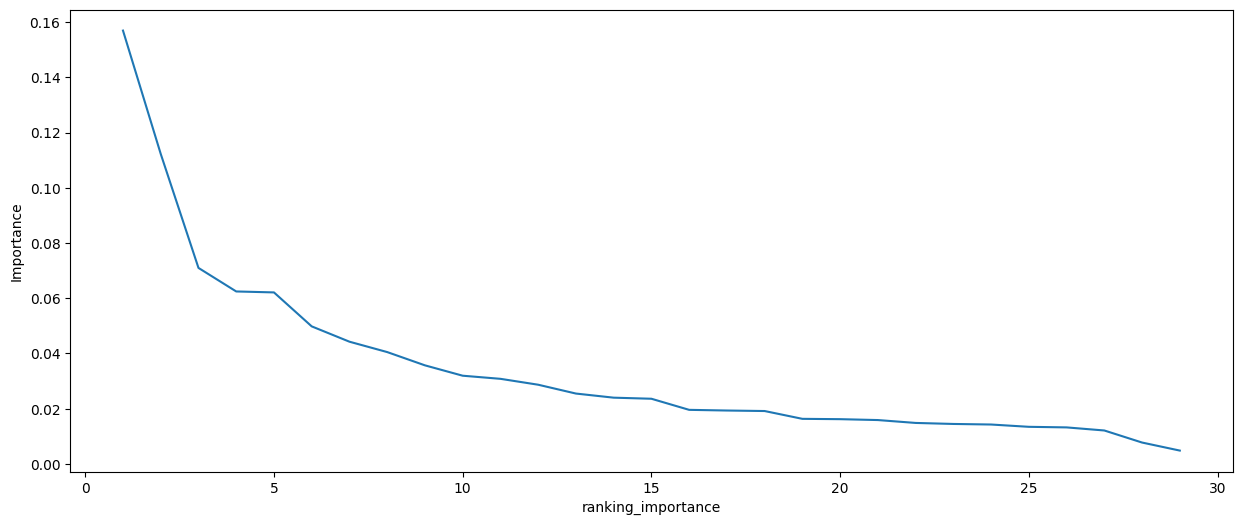

In [104]:
feature_importances_df = pd.DataFrame()
feature_importances_df['feature'] = X_train.columns
feature_importances_df['Importance'] = best_model.feature_importances_
feature_importances_df  = feature_importances_df.sort_values('Importance', ascending=False)
feature_importances_df['ranking_importance'] = np.arange(1, feature_importances_df.shape[0]+1, 1)

plt.figure(figsize = (15,6))
sns.lineplot(data = feature_importances_df, x = 'ranking_importance', y = 'Importance')
plt.show()

In [105]:
feature_importances_df

,feature,Importance,ranking_importance
2,international_plan,0.156956,1
3,number_customer_service_calls,0.112266,2
17,voice_mail_plan,0.070966,3
7,total_day_minutes,0.062436,4
22,state_OH,0.062089,5
6,total_day_charge,0.049785,6
27,state_WY,0.044234,7
13,total_intl_minutes,0.040473,8
4,number_vmail_messages,0.035666,9
20,state_ID,0.031911,10


In [106]:
feature_importances_df['Importance_cumsum'] = feature_importances_df['Importance'].cumsum()

# can set importance_threshold to appropriate percentage of cumulative Importance that you want to cutoff features at
importance_threshold = 0.70
print(len(feature_importances_df[round(feature_importances_df['Importance_cumsum'], 2) <= importance_threshold]), 'features at or below threshold of', str(int(round(importance_threshold * 100, 0))) + '%')
display(feature_importances_df[round(feature_importances_df['Importance_cumsum'], 2) <= importance_threshold].head(5))
feature_importances_df[round(feature_importances_df['Importance_cumsum'], 2) <= importance_threshold].tail(5)

11 features at or below threshold of 70%


,feature,Importance,ranking_importance,Importance_cumsum
2,international_plan,0.156956,1,0.156956
3,number_customer_service_calls,0.112266,2,0.269222
17,voice_mail_plan,0.070966,3,0.340188
7,total_day_minutes,0.062436,4,0.402625
22,state_OH,0.062089,5,0.464714


,feature,Importance,ranking_importance,Importance_cumsum
27,state_WY,0.044234,7,0.558733
13,total_intl_minutes,0.040473,8,0.599206
4,number_vmail_messages,0.035666,9,0.634872
20,state_ID,0.031911,10,0.666783
12,total_intl_charge,0.030782,11,0.697565


In [107]:
best_nb = len(feature_importances_df[round(feature_importances_df['Importance_cumsum'], 2) <= importance_threshold]) 
best_features = list(feature_importances_df[0:best_nb]['feature'])
len(best_features)

11

## Down Sampling

In [70]:
X_FE.columns = X_FE.columns.str.split('.').str[0]
import importlib
Pipe_Mod = Pipeline([
            ('Down Sampling', pp.Down_Sampling(target='Churn'))
            ])

In [71]:
X_train_down, y_train_down = Pipe_Mod.fit_transform(pd.concat([X_train, y_train], axis = 1), y = None)

**************************************************
Down Sampling**************************************************


## Model Training

In [108]:
# Calculate the ratio of negative class to positive class
ratio = float(y_train.value_counts()[0] / y_train.value_counts()[1])
ratio

7.351893095768374

In [109]:
'Churn' in best_features # Making sure that target is not among the independent feature's list

False

In [110]:
importlib.reload(pp)
start=time.time()
### get best hyper parameters
best_model_after_fs = pp.grid_search(X_train[best_features], y_train, cv =  3, ratio = ratio)
end=time.time()
print ("time_spend: "+str(end-start))

**************************************************
get best hyper parameters

time_spend: 8.922785758972168


In [111]:
best_model_after_fs

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False, eta=0.05,
              eval_metric=None, gamma=0.3, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.0500000007, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, predictor='auto',
              random_state=500, reg_alpha=0, ...)

In [113]:
filename = 'Outputs/telecom_churn_model_v2.sav'
pickle.dump(best_model_after_fs, open(filename,'wb'))

In [115]:
# best_features = list(X_train.columns)

filename = 'Outputs/best_features_v2.sav'
pickle.dump(best_features, open(filename,'wb'))
print(len(best_features))

11


In [116]:
# filename = 'Outputs/Incomplete_Installation_prediction_best_model_v4.sav'
# best_model_after_fs = pickle.load(open(filename, 'rb'))

# filename = 'Outputs/best_features_v4.sav'
# best_features = pickle.load(open(filename, 'rb'))

In [117]:
for col in best_features:
    if 'Churn' in col:
        print(col)

## Model Evaluations and Lift Analysis

In [118]:
best_model_after_fs

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False, eta=0.05,
              eval_metric=None, gamma=0.3, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.0500000007, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, predictor='auto',
              random_state=500, reg_alpha=0, ...)

In [119]:
X_test[best_features]

,international_plan,number_customer_service_calls,voice_mail_plan,total_day_minutes,state_OH,total_day_charge,state_WY,total_intl_minutes,number_vmail_messages,state_ID,total_intl_charge
1560,0.0,0.0,0.0,141.0,0.0,24.0,0.0,10.0,0.0,0.0,2.0
3819,0.0,0.0,1.0,184.0,0.0,31.0,0.0,16.0,19.0,0.0,4.0
3412,0.0,1.0,1.0,215.0,0.0,36.0,0.0,7.0,22.0,0.0,2.0
234,0.0,1.0,0.0,213.0,0.0,36.0,0.0,9.0,0.0,0.0,2.0
2139,0.0,3.0,0.0,174.0,0.0,29.0,0.0,9.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
4231,0.0,4.0,1.0,113.0,0.0,19.0,0.0,12.0,25.0,0.0,3.0
1926,0.0,0.0,0.0,132.0,0.0,22.0,0.0,5.0,0.0,0.0,1.0
4589,1.0,4.0,0.0,186.0,0.0,31.0,0.0,12.0,0.0,0.0,3.0
2459,0.0,0.0,0.0,129.0,0.0,22.0,0.0,13.0,0.0,0.0,3.0


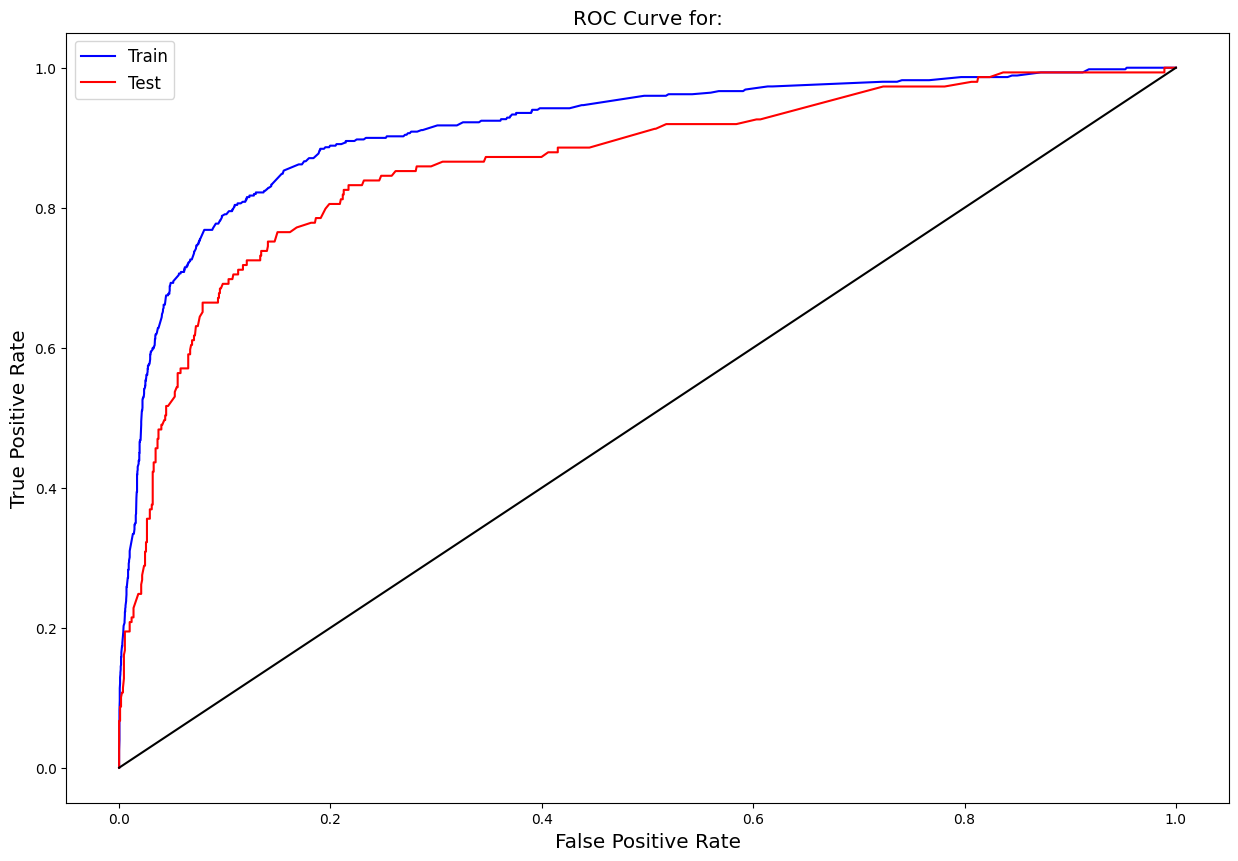

<Figure size 640x480 with 0 Axes>

In [120]:
importlib.reload(pp)
[metrics_summary, y_test_pred, y_test_proba, y_train_proba,y_proba,y_pred] = pp.model_evaluation (best_model_after_fs,X_train[best_features], y_train, X_train[best_features], y_train, X_test[best_features], y_test, X_FE[best_features], y)

In [121]:
metrics_summary

,Training down_sample,Training,Testing
Accuracy,0.857333,0.857333,0.844000
Recall,0.824053,0.824053,0.751678
Precision,0.447942,0.447942,0.414815
F1-Score,0.580392,0.580392,0.534606


In [122]:
from sklearn import metrics
#calculate AUC of model
auc = metrics.roc_auc_score(y_test, y_test_proba)

#print AUC score
print(auc)

0.8647202969844376


In [123]:
id

['ID']

In [125]:
## Build final data
df_predict_actual                   = pd.DataFrame()
df_predict_actual['predict']        = y_pred
df_predict_actual['predict_prob']   = y_proba
df_predict_actual['customerID']         = raw_data_res['ID']

df_predict_actual.head()

,predict,predict_prob,customerID
0,0,0.212251,1000
1,0,0.202275,1001
2,0,0.077219,1002
3,1,0.745720,1003
4,0,0.205319,1004


In [126]:
df_fixed    = df_predict_actual.sort_values(by = 'predict_prob', ascending = False).reset_index()
sample_size = df_predict_actual.shape[0]

# Segment the data into Decile size of 1
decile_size = sample_size/100 
df_fixed['Rank'] = ((df_predict_actual.index//decile_size)*1+1).astype('int64')

# df_fixed2 = df_fixed[df_fixed['Rank'] <= 20][['chc_id', 'Rank']]
df_fixed2 = df_fixed[['customerID', 'Rank']]
df_fixed2.head()

,customerID,Rank
0,2830,1
1,3240,1
2,4884,1
3,3444,1
4,1180,1


## KS 

In [127]:
test_df = pd.concat([X_test[best_features], y_test], axis = 1)
test_df['Churn_probability'] = y_test_proba
test_df['y_pred'] = y_test_pred

In [128]:
y_test.sum()

149

In [129]:
test_df.shape

(1250, 14)

In [130]:
test_df.Churn.value_counts()

Churn
0    1101
1     149
Name: count, dtype: int64

In [131]:
importlib.reload(pp)
ks_df = pp.ks(data=test_df,target="Churn", prob= "Churn_probability")

In [132]:
ks_df

,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS
Decile,,,,,,,,,
1,0.767571,0.973905,76,49,51.01%,4.45%,51.01%,4.45%,4.655621e-01
2,0.585248,0.767509,32,92,21.48%,8.36%,72.48%,12.81%,5.967668e-01
3,0.382598,0.580556,16,107,10.74%,9.72%,83.22%,22.52%,6.069650e-01
4,0.195839,0.372105,5,123,3.36%,11.17%,86.58%,33.70%,5.288054e-01
5,0.154954,0.195727,3,119,2.01%,10.81%,88.59%,44.50%,4.408561e-01
6,0.147505,0.154735,5,113,3.36%,10.26%,91.95%,54.77%,3.717792e-01
7,0.141426,0.147329,1,65,0.67%,5.90%,92.62%,60.67%,3.194533e-01
8,0.135191,0.141426,7,158,4.70%,14.35%,97.32%,75.02%,2.229273e-01
9,0.120683,0.134719,3,151,2.01%,13.71%,99.33%,88.74%,1.059135e-01


In [ ]:
ks_df

,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS
Decile,,,,,,,,,
1,0.702077,0.985995,82,334,65.08%,8.24%,65.08%,8.24%,0.568406
2,0.573361,0.699667,18,400,14.29%,9.87%,79.37%,18.11%,0.612595
3,0.503984,0.573209,15,393,11.90%,9.69%,91.27%,27.80%,0.634701
4,0.145940,0.503301,4,426,3.17%,10.51%,94.44%,38.31%,0.561366
5,0.076579,0.145418,2,412,1.59%,10.16%,96.03%,48.47%,0.475611
6,0.056283,0.076036,0,398,0.00%,9.82%,96.03%,58.29%,0.377436
7,0.044192,0.056267,1,435,0.79%,10.73%,96.83%,69.02%,0.278071
8,0.034204,0.044162,1,419,0.79%,10.34%,97.62%,79.35%,0.182653
9,0.028435,0.034155,1,393,0.79%,9.69%,98.41%,89.05%,0.093648


## SHAP Feature Importance

In [133]:
import shap
explainer = shap.Explainer(best_model_after_fs, X_test[best_features])
shap_values = explainer(X_test[best_features])

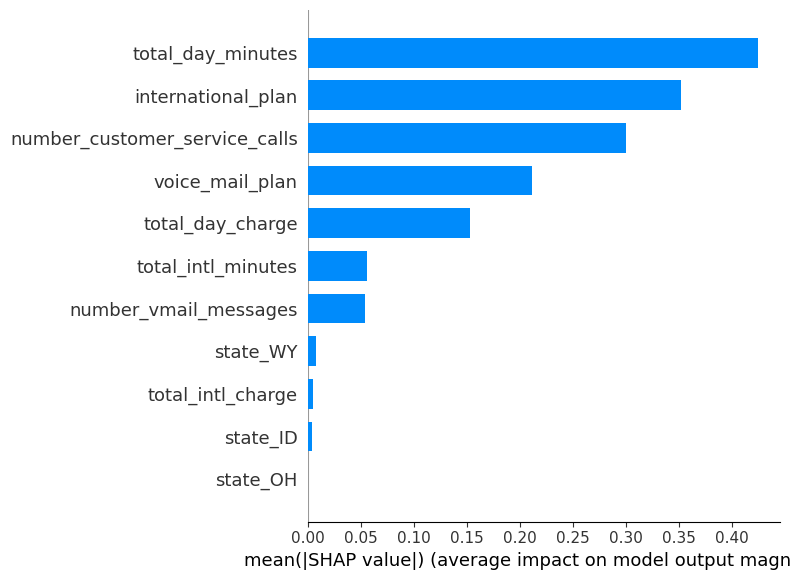

In [134]:
shap.summary_plot(shap_values, X_test[best_features], plot_type= 'bar')

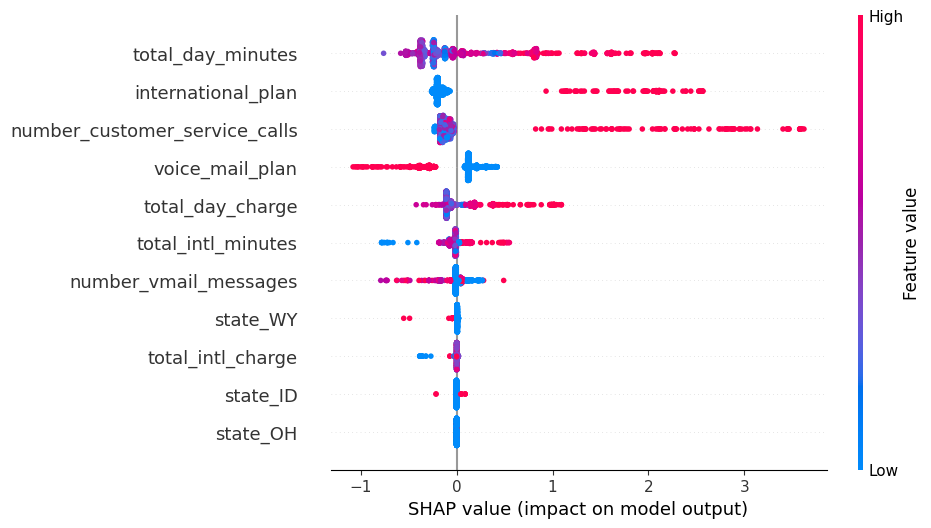

In [135]:
shap.plots.beeswarm 

In [137]:
import shap

In [138]:
X_display,y_display = shap.datasets.adult(display=True)

In [139]:
X_display

,Age,Workclass,Education-Num,Marital Status,...,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,...,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,...,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,...,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,...,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,...,0.0,0.0,40.0,Cuba
...,...,...,...,...,...,...,...,...,...
32556,27.0,Private,12.0,Married-civ-spouse,...,0.0,0.0,38.0,United-States
32557,40.0,Private,9.0,Married-civ-spouse,...,0.0,0.0,40.0,United-States
32558,58.0,Private,9.0,Widowed,...,0.0,0.0,40.0,United-States
32559,22.0,Private,9.0,Never-married,...,0.0,0.0,20.0,United-States


In [140]:
y_display

array([False, False, False, ..., False, False,  True])